In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
import h5py
from tqdm import tqdm

In [2]:
# initialize constants (SI units)
c = 2.99792458e8 #speed of light
m_e = 9.10938356e-31
q_e = 1.60217662e-19
e_0 = 8.85418782e-12
# set pure spectral properties
lambda_0 = 800e-9  # central wavelength
tau_0 = 10e-15  # FL pulse duration 1/e2 intensity half-width (same def as beam waist)
# quick frequency properties
omega_0 = 2*np.pi*c/lambda_0
# set initial beam waist
w_00 = 2e-6
# calculate Rayleigh range and beam waist
z_R0 = (omega_0*w_00**2)/(2*c)
z_R = np.copy(z_R0)

In [3]:
GDD_0 = 0  # Group Delay Dispersion fs^2
GDD = GDD_0*(1e-15)**2
tau_p = np.sqrt(tau_0**2 + (2*GDD/tau_0)**2)
# beam power
P = 5.5e12
Amp = np.sqrt(8*P/(np.pi*e_0*c))
# set tuning parameters
z_0 = np.linspace(-1*z_R0, +1*z_R0, 3, endpoint=True)
Psi_0 = np.linspace(0, 2*np.pi, 2, endpoint=False)

In [4]:
t_start = -50*tau_0
t_end = +400*tau_0
n = 50
# create variables
beta_final = np.zeros(shape=(len(z_0),len(Psi_0)))
KE_final = np.zeros(shape=(len(z_0),len(Psi_0)))
#loop over inital position of test particle
for i in range(0, len(z_0)):
    # loop over CEO phase of laser
    for j in range(0, len(Psi_0)):
        num_t = np.int_(np.round(n*(t_end-t_start)/(lambda_0/c)))
        time = np.linspace(t_start,t_end,num_t)
        dt = time[1]-time[0]
        z = np.empty(shape=(len(time)))
        beta = np.empty(shape=(len(time)))
        deriv1 = np.empty(shape=(len(time)))
        deriv2 = np.empty(shape=(len(time)))
        beta[0] = 0.0
        z[0] = beta[0]*c*time[0]+z_0[i]

        # do 5th order Adams-Bashforth finite difference method
        for k in tqdm(range(0, len(time)-1)):
            deriv1[k] = beta[k]*c
            
            field_temp = np.cos(Psi_0[j]+2*np.arctan(z[k]/z_R0)+omega_0*time[k]-omega_0*z[k]/c)/(z_R0*(1+(z[k]/z_R0)**2))
            env_temp = np.exp(-((time[k]-z[k]/c)/tau_p)**2)
            temp_phase = np.exp(1j*(2*GDD/(tau_0**4+(2*GDD)**2))*(time[k]-z[k]/c)**2)
            field_total = Amp*(tau_0/tau_p)*field_temp*env_temp*temp_phase
            deriv2[k] = (-q_e*np.real(field_total)*((1-beta[k]**2)**(3/2))/(m_e*c))
            if k==0:
                z[k+1] = z[k] + dt*deriv1[k]
                beta[k+1] = beta[k] + dt*deriv2[k]
            elif k==1:
                z[k+1] = z[k] + dt*(1.5*deriv1[k]-0.5*deriv1[k-1])
                beta[k+1] = beta[k] + dt*(1.5*deriv2[k]-0.5*deriv2[k-1])
            elif k==2:
                z[k+1] = z[k] + dt*((23/12)*deriv1[k]-(4/3)*deriv1[k-1]+(5/12)*deriv1[k-2])
                beta[k+1] = beta[k] + dt*((23/12)*deriv2[k]-(4/3)*deriv2[k-1]+(5/12)*deriv2[k-2])
            elif k==3:
                z[k+1] = z[k] + dt*((55/24)*deriv1[k]-(59/24)*deriv1[k-1]+(37/24)*deriv1[k-2]-(3/8)*deriv1[k-3])
                beta[k+1] = beta[k] + dt*((55/24)*deriv2[k]-(59/24)*deriv2[k-1]+(37/24)*deriv2[k-2]-(3/8)*deriv2[k-3])
            else:
                z[k+1] = z[k] + dt*((1901/720)*deriv1[k]-(1387/360)*deriv1[k-1]+(109/30)*deriv1[k-2]-(637/360)*deriv1[k-3]+(251/720)*deriv1[k-4])
                beta[k+1] = beta[k] + dt*((1901/720)*deriv2[k]-(1387/360)*deriv2[k-1]+(109/30)*deriv2[k-2]-(637/360)*deriv2[k-3]+(251/720)*deriv2[k-4])
                
        KE = ((1/np.sqrt(1-beta**2))-1)*m_e*c**2/q_e
        beta_final[i,j] = beta[-1]
        KE_final[i,j] = KE[-1]
        print(str(i+1)+':'+str(j+1))

beta_final = xr.DataArray(beta_final, coords=[z_0/z_R0, Psi_0], dims=['z_0', 'CEO'])
KE_final = xr.DataArray(KE_final, coords=[z_0/z_R0, Psi_0], dims=['z_0', 'CEO'])

  2%|█▌                                                                        | 1841/84316 [00:00<00:05, 16174.75it/s]

1:1


  2%|█▍                                                                        | 1701/84316 [00:00<00:05, 15451.69it/s]

1:2


  4%|██▉                                                                       | 3413/84316 [00:00<00:04, 16581.14it/s]

2:1


  4%|██▊                                                                       | 3145/84316 [00:00<00:05, 15533.90it/s]

2:2


  2%|█▍                                                                        | 1658/84316 [00:00<00:05, 16052.40it/s]

3:1


100%|█████████████████████████████████████████████████████████████████████████| 84316/84316 [00:05<00:00, 15706.13it/s]

3:2


<xarray.DataArray ()>
array(881466.47539467)


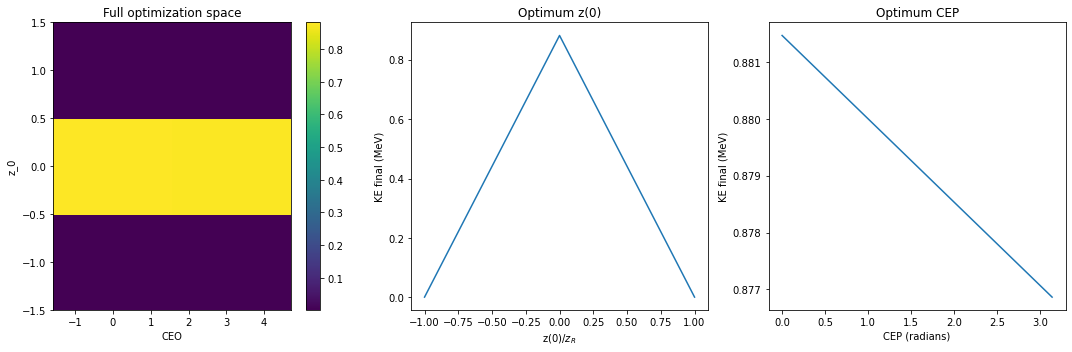

In [5]:
plt.figure(figsize=(15,5))

ax1=plt.subplot(1,3,1)
(KE_final/1e6).plot()
ax1.set_title('Full optimization space')
ax2=plt.subplot(1,3,2)
plt.plot(z_0/z_R0,np.max(KE_final,1)/1e6)
plt.xlabel('z(0)/$z_R$')
plt.ylabel('KE final (MeV)')
ax2.set_title('Optimum z(0)')
ax3=plt.subplot(1,3,3)
plt.plot(Psi_0,np.max(KE_final,0)/1e6)
plt.xlabel('CEP (radians)')
plt.ylabel('KE final (MeV)')
ax3.set_title('Optimum CEP')

plt.tight_layout()

#plt.savefig('data/NoSTC_OnAxis_'+str(np.int_(P/1e12))+'TW_'+str(np.int_(tau_0*1e15))+'fs_'+str(np.int_(w_00*1e6))+'um_'+str(beta[0])+'_optimization.png')

print(np.max(np.max(KE_final)))

In [6]:
#h5f = h5py.File('data/NoSTC_OnAxis_'+str(np.int_(P/1e12))+'TW_'+str(np.int_(tau_0*1e15))+'fs_'+str(np.int_(w_00*1e6))+'um_'+str(beta[0])+'_optimization.hdf5', 'w')
#h5f.create_dataset('KE', data=KE_final.data)
#h5f.create_dataset('CEO', data=KE_final.coords['CEO'].values)
#h5f.create_dataset('z_0', data=KE_final.coords['z_0'].values)
#h5f.close()

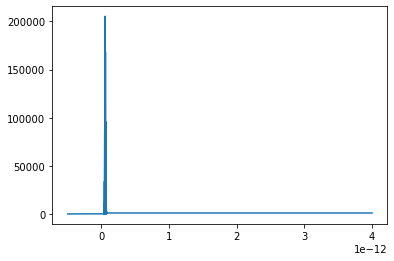

In [7]:
plt.plot(time, KE)